# Tutorial 2a: Tidy data and split-apply-combine

(c) 2018 Justin Bois. With the exception of pasted graphics, where the source is noted, this work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

This document was prepared at [Caltech](http://www.caltech.edu) with financial support from the [Donna and Benjamin M. Rosen Bioengineering Center](http://rosen.caltech.edu).

<img src="caltech_rosen.png">

*This tutorial was generated from an Jupyter notebook.  You can download the notebook [here](t2a_tidy_data.ipynb).*

In [1]:
import itertools

import numpy as np
import pandas as pd

import altair as alt

In [Tutorial 1](t1b_exploratory_data_analysis.html), we used data on frog tongue adhesion to learn about data frames and a bit about plotting data.  That data set was relatively small and fairly easy to plot and investigate.  That is not to say it was trivial!

In this tutorial, we will work with a more complicated data set, which can be downloaded [here](../data/gandhi_et_al.zip).

The data we are investigating come from [David Prober](http://proberlab.caltech.edu/)'s lab.  A description of their work on the genetic regulation of sleep can be found on the [research page](http://www.proberlab.caltech.edu/Research) of the lab website.  There is a movie of the moving/sleeping larvae similar to the one used to produce the data set we are using in this tutorial.  The work based on this data set was published in ([Gandhi et al., *Neuron*, **85**, 1193–1199, 2015](http://bebi103.caltech.edu/2017_protected/papers/gandhi_2015.pdf)).

In the experiment we are analyzing in this tutorial, we study the effect of a deletion  in the gene coding for arylalkylamine N-acetyltransferase (*aanat*), which is a key enzyme in the rhythmic production of melatonin.  Melatonin is a hormone responsible for regulation of circadian rhythms.  It is often taken as a drug to treat sleep disorders.  The goal of this study is to investigate the effects of aanat deletion on sleep pattern in 5+ day old zebrafish larvae.

In our data set, we have data on the movement of zebrafish larvae over time for wild type, heterozygous mutant, and homozygous mutant zebrafish.

To understand how the data were taken, here is the text of the Methods section of [Prober, et al., *J. Neurosci.*, **26**, 13400-13410, 2006](..//protected/papers/prober_2006.pdf).
>Larvae were raised on a 14/10 h light/dark (LD) cycle at 28.5°C. On the fourth day of development, single larva were placed in each of 80 wells of a 96-well plate (7701-1651; Whatman, Clifton, NJ), which allowed simultaneous tracking of each larva and prevented the larvae from interfering with the activity of each other. Locomotor activity was monitored for several days using an automated video-tracking system (Videotrack; ViewPoint Life Sciences, Montreal, Quebec, Canada) with a Dinion one-third inch Monochrome camera (model LTC0385; Bosch, Fairport, NY) fitted with a fixed-angle megapixel lens (M5018-MP; Computar) and infrared filter, and the movement of each larva was recorded using Videotrack quantization mode. The 96-well plate and camera were housed inside a custom-modified Zebrabox (ViewPoint Life Sciences) that was continuously illuminated with infrared lights and was illuminated with white lights from 9:00 A.M. to 11:00 P.M. The 96-well plate was housed in a chamber filled with circulating water to maintain a constant temperature of 28.5°C. The Videotrack threshold parameters for detection were matched to visual observation of the locomotion of single larva. The Videotrack quantization parameters were set as follows: detection threshold, 40; burst (threshold for very large movement), 25; freeze (threshold for no movement), 4; bin size, 60 s. The data were further analyzed using custom PERL software and Visual Basic Macros for Microsoft (Seattle, WA) Excel. Any 1 min bin with zero detectable movement was considered 1 min of rest because this duration of inactivity was correlated with an increased arousal threshold; a rest bout was defined as a continuous string of rest minutes. Sleep latency was defined as the length of time from lights out to the start of the first rest bout. An active minute was defined as a 1 min bin with any detectable activity. An active bout was considered any continuous stretch of 1 min bins with detectable movement.

The data set that comes out of the instrument is an archaic MS Excel (gasp!) format. I converted it to CSV using MS Excel (Pandas can read in Excel files, but not this very old format). I then did some processing to get it in its current form. You will work with the original data files next week when we talk about validation. 

The data set comes from the automated instrument/camera system (Videotrack) that measures the fish. Additionally, we have a file that was manually created by the experimenter, Anvi Gandhi, a former grad student in the Prober lab. It contains the genotypes of the fish obtained by sequencing after the behavioral experiment was completed.

In this tutorial, we will first tidy the genotype file (it is not tidy). We will then perform some computations and manipulations on the tidy data of the behavioral data file.

## Tidy data

As a reminder, our goal is to work with **tidy data** (see [this paper](http://www.jstatsoft.org/article/view/v059i10) and [this paper](https://www.jstatsoft.org/article/view/v040i01) by [Hadley Wickham](https://en.wikipedia.org/wiki/Hadley_Wickham)). Tidy data refers to data sets arranged in tabular form that have the following format.

1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a separate table.

As we already saw in the last set of tutorials, structuring the data in this way allows for very easy access by Boolean indexing and easy plotting using high-level plotting libraries like Altair. Furthermore, if you know a priori that a data set is tidy, there is little need for wrangling; you already know how to pull out what you need. Really, the wrangling is all about getting the data into tidy format (and wrangling is one of the main things we are covering in this tutorial).

You may raise some objections about tidy data. Here are a few, and my responses.

<br />

**Objection:** Looking at a table of tidy data is ugly. It is not intuitively organized. I would almost never display a tidy data table in a publication.

**Response:** Correct! Having tabular data in a format that is easy to read as a human studying a table is a very different thing than having it in a format that is easy to explore and work with using a computer. As my friend [Daniel Chen](https://chendaniely.github.io) put it, "There are data formats that are better for reporting and data formats that are better for analysis." We are using the tidy data frames for analysis, not reporting (though having the data in a tidy format makes making plots much easier, and plots are a key medium for reporting.)

<br />

**Objection:** Isn't it better to sometimes have data arranged in other ways? Say in a matrix?

**Response:** This is certainly true for things like images, or raster-style data in general. It makes more sense to organize an image in a 2D matrix than to have it organized as a data frame with three columns (row in image, column in image, intensity of pixel), where each row corresponds to a single pixel. For an image, indexing it by row and column is always unambiguous, `my_image[i, j]` means the pixel at row `i` and column `j`.

For other data, though, the matrix layout suffers from the fact that there may be more than one way to construct a matrix. If you know a data frame is tidy, you already know its structure. You need only to ask what the columns are, and then you immediately know how to access data. In other formats, you might have to read and write extensive comments to understand the structure of the data. Of course, you *can* read and write comments, but it opens the door for the possibility of misinterpretation or mistakes.

<br />

**Objection:** But what about time series? Clearly, that can be in matrix format. One column is time, and then subsequent columns are observations made at that time.

**Response:** Yes, that is true. But then the matrix-style described could be considered tidy, since each row is a single observation (time point) that has many facets.

<br />

**Objection:** Isn't this an inefficient use of memory? There tend to be lots of repeated entries in tidy data frames.

**Response:** Yes, there are more efficient ways of storing and accessing data. But for data sets that are not "big data," this is seldom a real issue. The extra expense in memory, as well as the extra expense in access, is a small prices to pay for the simplicity and speed of the human user in accessing the data. This is particularly true in exploratory data analysis (EDA), as we will see in the next tutorial.

<br />

**Objection:** Once it's tidy, we pretty much have to use Boolean indexing to get what we want, and that can be slower than other methods of accessing data. What about performance?

**Response:** See the previous response. Speed of access really only because of a problem with big, high-throughput data sets. In those cases, there are often many things you need to be clever about.

<br />

**Conclusion:** I really think that tidying a data set allows for fluid exploration. We will focus on tidy data sets going forward, and in this tutorial will show some techniques for tidying them.

Now, onwards toward our analysis of the zebrafish sleep data.

## Data file names

First, we need to unzip the data set using your favorite unzipper.  You will have two data files.  One is `130315_1A_genotypes.txt`, which specifies the genotype of the larva in each well. This file was generated by hand by a human researcher after looking at sequencing data from each of the fish. The other is `130315_1A_aanat2.csv`, which contains (you guessed it) the raw data from each well, as well as the time points for acquisition.

I pause for a moment to comment that these are essentially the file names that I received from the Prober lab.  Their method of naming their files is a good one, I think, and one that I use in my own research.  By naming first with a six-digit year-month-day code, they will appear in chronological order on your computer, which makes it easier to reference against your lab notebook. They also annotate the file name with the instrument used to acquire the data; its instrument "1A." Finally, they give the genotype of the fish they are studying. 

Now, because these are long experiments, the time is not also included.  In cases where I do several experiments in a day, I use a 12-digit code, where the last four digits are the 24-hour-style time that the experiment was done.  The file name after the time-stamp code should contain a description of the experiment itself. I might name a data set as `2017-09-20-1426_1A_aanat2.csv`.

## The genotype data

We'll first load the genotype file. Let's take a quick look first.

In [2]:
with open('../data/130315_1A_genotypes.txt', 'r') as f:
    for _ in range(30):
        print(next(f), end='')

# Genotype data from the Gandhi, et al. experiment ending March 13, 2013
#
# The experiment was performed in a 96 well plate with zebrafish
# embryos.  Gene sequencing was later used to identify the genotype
# of the fish in each well.  Not all fish could be genotyped.
#
# The mutants being studied have deletions in the gene coding for
# arylalkylamine N-acetyltransferase (aanat), which is a key enzyme
# in the rhythmic production of melatonin.  Melatonin is a hormone
# responsible for regulation of circadian rhythms.  It is often taken
# as a drug to treat sleep disorders.  The goal of this study is to
# investigate the effects of aanat deletion on sleep pattern in
# 5+ day old zebrafish larvae.
#
# Each column lists the wells corresponding to the genotype of
# each fish.  If a number is missing (between 1 and 96), the 
# genotype of that fish is not known.
# 
# These data were kindly provided by Avni Gandhi and Audrey Chen
# from David Prober's lab.  They were part of the paper Gandh

Each column (apparently tab delimited) in this file contains a list of wells in the 96 well plate corresponding to each genotype. We can parse this using the `delimiter` keyword argument of `pd.read_csv()`.  When specifying the delimiter, tabs are denoted as `\t`.

We also see that there are two header rows.  The first is really redundant, so we can skip it.  Nonetheless, we will read both in as headers using the `header` kwarg of `pd.read_csv()`.

In [3]:
# Load in the genotype file, call it df_gt for genotype DataFrame
df_gt = pd.read_csv('../data/130315_1A_genotypes.txt',
                    delimiter='\t',
                    comment='#',
                    header=[0, 1])

# Take a look at it
df_gt

Genotype1 Genotype2 Genotype3
       WT 17    Het 34    Mut 22
0        2.0         1       4.0
1       14.0         3      11.0
2       18.0         5      12.0
3       24.0         6      13.0
4       28.0         8      20.0
5       29.0        10      21.0
6       30.0        15      23.0
7       54.0        19      27.0
8       58.0        22      35.0
9       61.0        33      39.0
10      68.0        36      46.0
11      75.0        38      56.0
12      76.0        40      60.0
13      78.0        43      64.0
14      80.0        44      66.0
15      86.0        47      67.0
16      96.0        49      69.0
17       NaN        51      87.0
18       NaN        52      89.0
19       NaN        53      92.0
20       NaN        55      79.0
21       NaN        57      81.0
22       NaN        59       NaN
23       NaN        62       NaN
24       NaN        65       NaN
25       NaN        71       NaN
26       NaN        72       NaN
27       NaN        73       NaN
28       NaN        74       NaN
29       NaN        77       NaN
30       NaN        88       NaN
31       NaN        90       NaN
32       NaN        93       NaN
33       NaN        95       NaN

We notice that we have two header rows for the columns.  If we look at the column names, we see that they are a `MultiIndex` instance.

In [4]:
df_gt.columns

MultiIndex(levels=[['Genotype1', 'Genotype2', 'Genotype3'], ['Het 34', 'Mut 22', 'WT 17']],
           labels=[[0, 1, 2], [2, 0, 1]])

This is part of Pandas's slick multi-indexing functionality, which is not something we need if we have tidy data.  (However, messy data using multi-indexing may result in performance boosts for accessing data.  This may become important for very large data sets.  In general, tidy data are easier to conceptualize and syntactically much simpler to access.)

We do not need the multi-indexing, and level zero of indexing (`'Genotype1'`, etc.) is not necessary.  So, we just want level one index.  This is easily obtained using the `get_level_values()` method of Pandas `MultiIndex` objects.

In [5]:
# Reset the columns to be the second level of indexing
df_gt.columns = df_gt.columns.get_level_values(1)

# Check out the new columns
df_gt.columns

Index(['WT 17', 'Het 34', 'Mut 22'], dtype='object')

The numbers at the end of these column headings say how many of each type were encountered.  These are dispensable, so let's clean up the column names.

In [6]:
df_gt.columns = ['wt', 'het', 'mut']

This approach is a shortcut to the `rename()` method we encountered in the tutorial last week. Note that we could have done this in the first place instead of messing around with the `MultiIndex`, but I wanted you to be aware of multi-indexing in Pandas and to recognize it when you encounter it. Many data sets you will encounter feature it, and you will need to know how to tidy data sets in this format.

### Tidying the genotype data

As they are, the data are not tidy.  For tidy data, we would have two columns, `'location'`, which give the well number for each larva, and `'genotype'`, which is `'wt'` for wild type, `'het'` for heterozygote, or `'mut'` for mutant.  

A useful tool for tidying data is the `pd.melt()` function.  For this simple data set, it takes the column headings and makes them into a column (with repeated entries) and puts the data accordingly in the correct order.  We just need to specify the name of the "variable" column, in this case the genotype, and the name of the "value" column, in this case the fish ID.

In [7]:
# Tidy the DataFrame
df_gt = pd.melt(df_gt, var_name='genotype', value_name='location')

# Take a look
df_gt

genotype  location
0         wt       2.0
1         wt      14.0
2         wt      18.0
3         wt      24.0
4         wt      28.0
5         wt      29.0
6         wt      30.0
7         wt      54.0
8         wt      58.0
9         wt      61.0
10        wt      68.0
11        wt      75.0
12        wt      76.0
13        wt      78.0
14        wt      80.0
15        wt      86.0
16        wt      96.0
17        wt       NaN
18        wt       NaN
19        wt       NaN
20        wt       NaN
21        wt       NaN
22        wt       NaN
23        wt       NaN
24        wt       NaN
25        wt       NaN
26        wt       NaN
27        wt       NaN
28        wt       NaN
29        wt       NaN
..       ...       ...
72       mut      20.0
73       mut      21.0
74       mut      23.0
75       mut      27.0
76       mut      35.0
77       mut      39.0
78       mut      46.0
79       mut      56.0
80       mut      60.0
81       mut      64.0
82       mut      66.0
83       mut      67.0
84       mut      69.0
85       mut      87.0
86       mut      89.0
87       mut      92.0
88       mut      79.0
89       mut      81.0
90       mut       NaN
91       mut       NaN
92       mut       NaN
93       mut       NaN
94       mut       NaN
95       mut       NaN
96       mut       NaN
97       mut       NaN
98       mut       NaN
99       mut       NaN
100      mut       NaN
101      mut       NaN

[102 rows x 2 columns]

The NaN entries were still preserved.  We can drop them using the `dropna()` method of `DataFrame`s.

In [8]:
# Drop all rows that have a NaN in them
df_gt = df_gt.dropna()

# Take a look
df_gt

genotype  location
0        wt       2.0
1        wt      14.0
2        wt      18.0
3        wt      24.0
4        wt      28.0
5        wt      29.0
6        wt      30.0
7        wt      54.0
8        wt      58.0
9        wt      61.0
10       wt      68.0
11       wt      75.0
12       wt      76.0
13       wt      78.0
14       wt      80.0
15       wt      86.0
16       wt      96.0
34      het       1.0
35      het       3.0
36      het       5.0
37      het       6.0
38      het       8.0
39      het      10.0
40      het      15.0
41      het      19.0
42      het      22.0
43      het      33.0
44      het      36.0
45      het      38.0
46      het      40.0
..      ...       ...
60      het      72.0
61      het      73.0
62      het      74.0
63      het      77.0
64      het      88.0
65      het      90.0
66      het      93.0
67      het      95.0
68      mut       4.0
69      mut      11.0
70      mut      12.0
71      mut      13.0
72      mut      20.0
73      mut      21.0
74      mut      23.0
75      mut      27.0
76      mut      35.0
77      mut      39.0
78      mut      46.0
79      mut      56.0
80      mut      60.0
81      mut      64.0
82      mut      66.0
83      mut      67.0
84      mut      69.0
85      mut      87.0
86      mut      89.0
87      mut      92.0
88      mut      79.0
89      mut      81.0

[73 rows x 2 columns]

Note, though, that the indices do have some skips.  This happened when we dropped the NaN's.  This is not really of concern, since we will not use them.  If it annoys you, though, you can use the `reset_index()` method.

In [9]:
df_gt = df_gt.reset_index(drop=True)

We now have a tidy `DataFrame`. There is a problem, though. The fish numbers are now `float`s. This happened because NaN is a float, so the column got converted to floats. We can reset the data type of the column to `int`s.

In [10]:
df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)

We now have a beautiful, tidy `DataFrame` of genotypes. I think it might be clear already to you that `pd.melt()` may be the single most useful function in tidying messy data sets. Now, let's proceed to the behavioral data.

## The behavioral data

Let's take an initial look at the behavioral data set. I have processed this set to some degree, and you will work with the original raw data set next week when you work on data validation. For now, let's look at the contents of the data file.

In [11]:
with open('../data/130315_1A_aanat2.csv', 'r') as f:
    for _ in range(40):
        print(next(f), end='')

# Lightly processed data from VideoTracker from the Gandhi, et al. experiment
# concluding on March 15, 2013.
#
# The experiment was performed in a 96 well plate with zebrafish
# embryos. Gene sequencing was later used to identify the genotype
# of the fish in each well. Not all fish could be genotyped.
#
# The mutants being studied have deletions in the gene coding for
# arylalkylamine N-acetyltransferase (aanat), which is a key enzyme
# in the rhythmic production of melatonin. Melatonin is a hormone
# responsible for regulation of circadian rhythms. It is often taken
# as a drug to treat sleep disorders. The goal of this study is to
# investigate the effects of aanat deletion on sleep pattern in
# 5+ day old zebrafish embryos.
#
# Activity is defined as the number of seconds over the one-minute interval 
# in which a given larva was moving.
#
# The column 'zeit' contains the so-called Zeitgeber time in units of hours.
# The Zeitgeber time is zero when the lights come on on the first 

The data set is tidy. Each row is the measured seconds of activity of a single fish for a single minute. Other information includes the time of the measurement and the day in the life of the fish. Note also what the comments say about the Zeitgeber time, contained in the `zeit` column. ("Zeit" is German for time.)

Let's load in this data set.

In [12]:
df = pd.read_csv('../data/130315_1A_aanat2.csv', comment='#')

# Take a look
df.head()

location  activity                 time       zeit  zeit_ind  day
0         1       0.6  2013-03-15 18:31:09 -14.480833      -869    4
1         2       1.4  2013-03-15 18:31:09 -14.480833      -869    4
2         3       0.0  2013-03-15 18:31:09 -14.480833      -869    4
3         4       0.0  2013-03-15 18:31:09 -14.480833      -869    4
4         5       0.0  2013-03-15 18:31:09 -14.480833      -869    4

## Adding the genotype information

Naturally, we would like to also include the genotype information for the fish at each location. Remember that the genotype `DataFrame`, `df_gt`, has two columns, `'location'` and `'genotype'`. The `'location`' column is shared with our behavior `DataFrame`, so we can use `pd.merge()` to add the genotype information as a new column.

In [13]:
df = pd.merge(df, df_gt)

# Take a look
df.head()

location  activity                 time       zeit  zeit_ind  day genotype
0         1       0.6  2013-03-15 18:31:09 -14.480833      -869    4      het
1         1       1.9  2013-03-15 18:32:09 -14.464167      -868    4      het
2         1       1.9  2013-03-15 18:33:09 -14.447500      -867    4      het
3         1      13.4  2013-03-15 18:34:09 -14.430833      -866    4      het
4         1      15.4  2013-03-15 18:35:09 -14.414167      -865    4      het

Boom. Yes, it's that easy.

## Is it light or dark?

We might also like to annotate our `DataFrame` to indicate if it is light of dark. That way, we can easily separate out activity that is during the day versus at night. So, we will make a column, `'light'`, where the entry is `True` if the lights are on, and `False` if the lights are off. Referring again to the comments in the header of the data set, the lights come on at 9AM and turn off at 11PM. We can use the `'time'` column to make this determination.

Let's investigate the time column for a moment. First, what is its data type?

In [14]:
df['time'].dtype

dtype('O')

This result `dtype('O')` means that its data type is "object," which is a generic catch-all for unknown data types. However, we know that the `'time'` column are actual clock times. We can tell Pandas this, and unleash its datetime processing power. We do this using the `pd.to_datetime()` function.

In [15]:
df['time'] = pd.to_datetime(df['time'])

# What is its type?
df['time'].dtype

dtype('<M8[ns]')

Now the data type is `<M8[ns]`, which is essentially saying that Pandas is aware that this is a point in time, and it is stored with nanosecond precision. (The weird symbol for this has to do with the [endianness](https://en.wikipedia.org/wiki/Endianness) of your machine, and we will not get into that.) This nanosecond precision is something to keep in mind when using datetime datetypes in Pandas. It has two main ramifications. First, if you are taking data at greater than nanosecond frequency (which is done on our campus), Pandas's datetime utility will not help you. That said, you don't really need it at that precision because you would use just a raw number of, say femtoseconds, as your time variable. The other consequence is that time zero can not be more than about a thousand years ago. This comes up in geology or fields like that. You don't really need the nanosecond precision there. Pandas does have the capability to make your own kind of datetime format that can handle these situations, but we will not delve into that here.

The nice thing about this data type is that you can now do lots of time-based things with it. For example, you can extract the time from the datetime. To extract this functionality, you can use the `.dt.time` attribute.

In [16]:
df['time'].dt.time.head()

0    18:31:09
1    18:32:09
2    18:33:09
3    18:34:09
4    18:35:09
Name: time, dtype: object

You can also compare times. For example, let's ask if the time is after 9AM.

In [17]:
(df['time'].dt.time > pd.to_datetime('9:00:00').time()).head()

0    True
1    True
2    True
3    True
4    True
Name: time, dtype: bool

Note that we had to convert the string `'9:00:00'` to datetime and then extract the time using the `time()` method.

Now, we can make a column of booleans that reports whether the time is greater than 9:00:00 and less than 23:00:00.

In [18]:
df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
               & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))

# Take a look
df.head()

location  activity                time       zeit  zeit_ind  day genotype  \
0         1       0.6 2013-03-15 18:31:09 -14.480833      -869    4      het   
1         1       1.9 2013-03-15 18:32:09 -14.464167      -868    4      het   
2         1       1.9 2013-03-15 18:33:09 -14.447500      -867    4      het   
3         1      13.4 2013-03-15 18:34:09 -14.430833      -866    4      het   
4         1      15.4 2013-03-15 18:35:09 -14.414167      -865    4      het   

   light  
0   True  
1   True  
2   True  
3   True  
4   True

It's hard to see if we got it right from the `DataFrame` itself, so let's make a quick plot of Zeitgeber time versus light. We only need to do this for a single location.

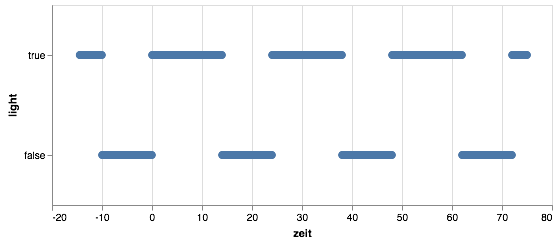

In [19]:
# Enable a bit more rows than usual to avoid an error
alt.data_transformers.enable('default', max_rows=6000)

alt.Chart(df.loc[df['location']==1, ['zeit', 'light']],
          height=200,
          width=500
    ).mark_point(
    ).encode(
        x='zeit:Q',
        y=alt.Y('light:N', sort=[True, False])
    )

Indeed, the lights switch on and off as they should.

## Split-apply-combine

Let's say we want to compute the average per-minute activity of each fish over the course of the entire experiment. Ignoring for the second the mechanics of how we would do this with Python, let's think about it in English. What do we need to do?

1. **Split** the data set up according to the `'location'` field, i.e., split it up so we have a separate data set for each fish.
2. **Apply** an averaging function to the activity in these split data sets.
3. **Combine** the results of these averages on the split data set into a new summary data set that contains the locations and means for each location.

We see that the strategy we want is a **split-apply-combine** strategy. This idea was put forward by Hadley Wickham in [this paper](https://www.jstatsoft.org/article/view/v040i01). It turns out that this is a strategy we want to use *very* often. **Split** the data in terms of some criterion. (We may want to split by genotype.) **Apply** some function to the split-up data. **Combine** the results into a new data frame.

Note that if the data are tidy, this procedure makes a lot of sense. Choose the column you want to use to split by. All rows with like entries in the splitting column are then grouped into a new data set.

Pandas's split-apply-combine operations are achieved using the `groupby()` method. You can think of `groupby()` as the splitting part. You can then apply functions to the resulting `DataFrameGroupBy` object. The [Pandas documentation on split-apply-combine](http://pandas.pydata.org/pandas-docs/stable/groupby.html) is excellent and worth reading through.

Let's put it to use in this example.

In [20]:
grouped = df.groupby('location')

# Take a look
grouped

### Aggregation

When we take a look at the `DataFrameGroupBy` object, we don't really see anything. That is because there is nothing to show, really. It is a split-up data set.

Now, let's compute the mean activity of each group. This type of operation is called an **aggregation**. That is, we split the data set up into groups, and then computed a summary statistic for each group, in this case the mean. Pandas has a built-in function to do this.

In [21]:
df_mean = grouped.mean()

# Take a look
df_mean.head()

activity       zeit     zeit_ind       day     light
location                                                      
1         2.684318  30.263574  1815.818199  5.743241  0.552489
2         3.296122  30.263574  1815.818199  5.743241  0.552489
3         2.030076  30.263574  1815.818199  5.743241  0.552489
4         4.527876  30.263574  1815.818199  5.743241  0.552489
5         4.255473  30.263574  1815.818199  5.743241  0.552489

We see that we get a `DataFrame` back. So, the `mean()` method of the `DataFrameGroupBy` object did both the **apply** and **combine** steps. This makes sense. You would never want to apply, and then not combine it into something useful. So, in Pandas, split-apply-combine to compute summary statistics is achieved by first doing a `groupby()` operation to get a `DataFrameGroupBy` object, and then an aggregation operation on it. The result is a `DataFrame`.

Looking at the result, though, we notice that the index of the `DataFrame` is now called `'location'`. This is because we grouped the original `DataFrame` (`df`) by `'location'`. It then applied the `np.mean()` function to every column of the original `DataFrame`. We really didn't want that; we only wanted it applied to `'activity'`. Let's try the operation again, this time slicing out the location column before applying the aggregating function.

In [22]:
df_mean = grouped['activity'].mean()

# Take a look
df_mean.head()

location
1    2.684318
2    3.296122
3    2.030076
4    4.527876
5    4.255473
Name: activity, dtype: float64

This is better. We now have a Pandas `Series`, where the index is `location`. Because we like to work with datasets with Boolean indexing, we would prefer a `DataFrame` with two columns, `'location'` and `'activity'`. We can get this using the `reset_index()` method.

In [23]:
df_mean = df_mean.reset_index()

# Take a look
df_mean.head()

location  activity
0         1  2.684318
1         2  3.296122
2         3  2.030076
3         4  4.527876
4         5  4.255473

Nice! Now, we know the average seconds of activity per minute for each fish.

### Transforms

Instead of summarizing data in a group with single summary statistics by aggregation, we can also do a **transformation** in which each row gets a new entry within a given group. As a simple example, we could generate a column that gives the rank of each fish in terms of its mean activity by applying a rank transform to the `df_mean` data frame.

In [24]:
df_mean['rank'] = df_mean['activity'].rank(method='first').astype(int)

#Take a look
df_mean.head()

location  activity  rank
0         1  2.684318    17
1         2  3.296122    37
2         3  2.030076     5
3         4  4.527876    64
4         5  4.255473    56

The `method=first` kwarg instructs the `rank()` method how to handle ties, as you can read about in the [docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rank.html).

While this transform was not applied to a `DataFrameGroupBy` object, the application to those objects is similar. We will see more of this momentarily.

### Aggregating and transforming with custom functions

Let's say we want to compute the coefficient of variation (CoV, the standard deviation divided by the mean) of data in columns of groups in the DataFrame. There is no built-in function to do this. We have to write our own function to compute the CoV and then use it with the `agg()` method of a `DataFrameGroupBy` object. In the function below, the values of each column are denoted by `data`.

In [25]:
def coeff_of_var(data):
    """Compute coefficient of variation from an array of data."""
    return np.std(data) / np.mean(data)

Now we can apply it as an aggregating function.

In [26]:
df_cov = grouped['activity'].agg(coeff_of_var).reset_index()

df_cov.head()

location  activity
0         1  0.989340
1         2  1.125340
2         3  1.456929
3         4  0.990083
4         5  1.028531

Note that by default, the column is labeled with the name of the column to which the transform was applied. We may wish you change the column name.

In [27]:
df_cov = df_cov.rename(columns=dict(activity='activity coefficient of variation'))

df_cov.head()

location  activity coefficient of variation
0         1                           0.989340
1         2                           1.125340
2         3                           1.456929
3         4                           0.990083
4         5                           1.028531

You can also define custom function and apply them using the `transform()` method. The `apply()` method can also be used for these purposes.

### Grouping by multiple columns

While the mean activity for each fish gives us some information, what we might *really* want is the mean activity for each genotype for each day and for each night. For this, we want to split the data set according to the `'genotype'`, `'day'`, and `'light'` columns. To do this, we simply pass a list of columns as the argument to the `groupby()` method.

In [28]:
# Group by three columns
grouped = df.groupby(['genotype', 'day', 'light'])

# Apply the mean and reset index
df_mean = grouped['activity'].mean().reset_index()

# Take a look
df_mean.head()

genotype  day  light  activity
0      het    4  False  0.447843
1      het    4   True  0.488257
2      het    5  False  0.900623
3      het    5   True  4.453268
4      het    6  False  1.125245

As another useful trick, we can compute other summary statistics, such as the standard deviation, all at once using the `agg()` method by passing multiple functions.

In [29]:
df_summary = grouped['activity'].agg([np.mean, np.std])

# Take a look
df_summary

mean       std
genotype day light                    
het      4   False  0.447843  1.131747
             True   0.488257  2.256494
         5   False  0.900623  1.551801
             True   4.453268  3.687598
         6   False  1.125245  1.650415
             True   5.994772  4.409796
         7   False  1.305324  1.941781
             True   6.699870  4.547888
         8   True   7.951300  4.640795
mut      4   False  0.663530  1.418944
             True   0.492886  2.080836
         5   False  2.405909  3.764114
             True   3.882942  3.057137
         6   False  3.037894  4.440587
             True   5.572538  3.882305
         7   False  2.841098  4.071158
             True   6.467198  5.106284
         8   True   7.199749  5.316255
wt       4   False  0.489333  1.142241
             True   0.555871  2.242828
         5   False  0.951853  1.365165
             True   4.989648  3.745862
         6   False  1.010559  1.388843
             True   6.685539  3.737201
         7   False  1.030118  1.527889
             True   6.349120  4.225148
         8   True   7.652779  4.130458

The columns are automatically named with the functions we chose to compute. We can add a `rename()` call and a `reset_index()` call to get the result we are after.

In [30]:
df_summary = (grouped['activity'].agg([np.mean, np.std])
                                 .reset_index()
                                 .rename(columns={'mean': 'mean activity',
                                                  'std': 'std activity'}))

# Take a look
df_summary.head()

genotype  day  light  mean activity  std activity
0      het    4  False       0.447843      1.131747
1      het    4   True       0.488257      2.256494
2      het    5  False       0.900623      1.551801
3      het    5   True       4.453268      3.687598
4      het    6  False       1.125245      1.650415

I'll use this new summary data frame to do a rank transform grouped by genotype.

In [31]:
df_summary['rank grouped by genotype'] = (df_summary.groupby('genotype')['mean activity']
                                                    .rank(method='first', ascending=False)
                                                    .astype(int))

df_summary.head()

genotype  day  light  mean activity  std activity  rank grouped by genotype
0      het    4  False       0.447843      1.131747                         9
1      het    4   True       0.488257      2.256494                         8
2      het    5  False       0.900623      1.551801                         7
3      het    5   True       4.453268      3.687598                         4
4      het    6  False       1.125245      1.650415                         6

This example shows the power of the split-apply-combine approach. You can very rapidly compute, and then compare, summary statistics, even from potentially large data sets.

## Resampling

**Resampling** of time series data (not to be confused with resampling-based statistical methods we will cover later in the course) is a common task. We currently have activity measurements of each fish in units of seconds of activity per minute; i.e., we have a one-minute sampling period. There is lots of high frequency noise, so we may wish to instead look at activity over the course of a longer time period. We will perform this resampling in a moment, but first, let's plot the activity for a single fish over time to visualize why we may want to do it. We will color the trace of the activity according to whether or not the light is on.

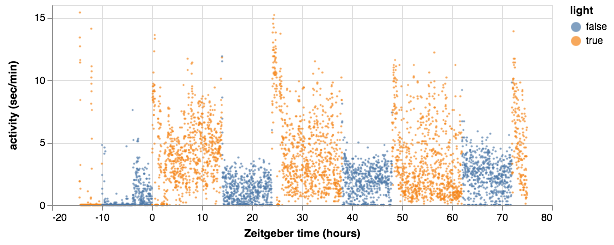

In [32]:
alt.Chart(df.loc[df['location']==1, ['zeit', 'activity', 'light']],
          height=200,
          width=500
    ).mark_circle(
        size=5
    ).encode(
        x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
        y=alt.Y('activity:Q', title='activity (sec/min)'),
        color='light:N',
        order='zeit:Q'
    )

We can see the difference between night and day quite strikingly. Note that effectively what happened here was a split-apply-combine operation. The data set is split into light and dark. A plot rendered operation is applied to each piece of the split data set and then combined into the final plot. 

This plot is fine and good, but we usually display these as line plots. So, let's do that.

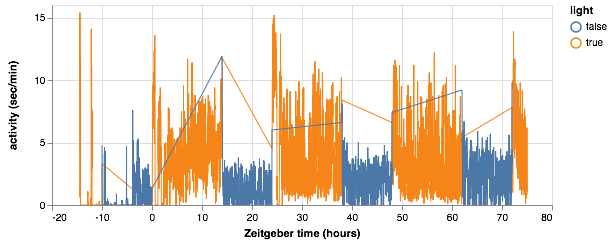

In [33]:
alt.Chart(df.loc[df['location']==1, ['zeit', 'activity', 'light']],
          height=200,
          width=500
    ).mark_line(
        strokeWidth=1,
        strokeJoin='bevel'
    ).encode(
        x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
        y=alt.Y('activity:Q', title='activity (sec/min)'),
        color='light:N',
        order='zeit:Q'
    )

Yikes! By encoding with color, Altair split the data, applied a line plot, and then rendered the final result. This results in night areas being connected and light areas also being connected. We can get around this issue by iterating over `day`-`light` pairs and then layering the plots. The strategy is to loop through each day, plot a line with light color when the lights were on, and a line with dark color when the lights were off. (Remember, "days" being and end at lights on, not a midnight.) Since we may do this again and again, I'll write a function to do it.

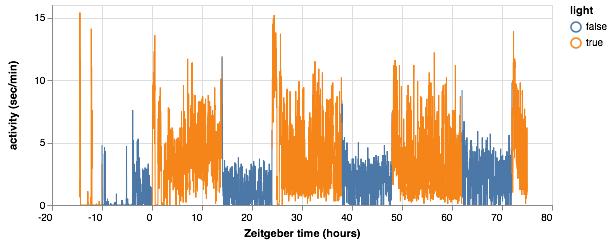

In [34]:
def plot_trace(df, col='activity', location=1, units='sec/min'):
    """Plot a trace, coloring by light."""
    charts = []
    for day, light in itertools.product(df['day'].unique(), 
                                        df['light'].unique()):
        inds = ( (df['location'] == location) 
                & (df['day'] == day) 
                & (df['light'] == light))

        charts.append(
            alt.Chart(df.loc[inds, ['zeit', col, 'light']],
                  height=200,
                  width=500
                ).mark_line(
                    strokeWidth=1,
                    strokeJoin='bevel'
                ).encode(
                    x=alt.X('zeit:Q', title='Zeitgeber time (hours)'),
                    y=alt.Y(f'{col}:Q', title=f'activity ({units})'),
                    color='light:N',
                    order='zeit:Q'
            )
        )

    return alt.layer(*charts)

plot_trace(df, col='activity', location=1)

This trace is quite noisy, since the fish are sometimes quiescent even when they are awake and darting around their well. It is sometimes better to consider a lower sampling frequency for the activity. We can sum the number of seconds of movement (which we call activity) over a longer time window than the default one minute, say ten minutes. There are several ways to do this.

First, we could do it by hand, looping over each location, and then performing the sum over each ten minute interval. We will not do that verbose method here, but will return to it later. Instead, I will demonstrate two ways to do it using built-in Pandas functions.

### Using rolling aggregation

First, we need to group the data set by `'location'`, since we want to resample the activity trace for each fish. The `DataFrameGroupBy` object has a `rolling()` method that will create an object over which you may compute rolling averages. Before we build this object, it is convenient to have the `DataFrame` sorted by `'location'` and then by `'zeit_ind'`, which is the index of the time point. This is a nice ordering, as each fish has their time trace in order, and then the fishes are in order. We can accomplish this sorting using the `DataFrame`'s `sort_values()` method, along with the `by` kwarg.

In [35]:
df = df.sort_values(by=['location', 'zeit_ind'])

# Take a look
df.head()

location  activity                time       zeit  zeit_ind  day genotype  \
0         1       0.6 2013-03-15 18:31:09 -14.480833      -869    4      het   
1         1       1.9 2013-03-15 18:32:09 -14.464167      -868    4      het   
2         1       1.9 2013-03-15 18:33:09 -14.447500      -867    4      het   
3         1      13.4 2013-03-15 18:34:09 -14.430833      -866    4      het   
4         1      15.4 2013-03-15 18:35:09 -14.414167      -865    4      het   

   light  
0   True  
1   True  
2   True  
3   True  
4   True

Now that it is sorted, let's create the `DataFrameGroupBy` object, and then generate a `RollingGroupby` object. We will only use the `zeit_ind` and `activity` columns. To make the `RollingGroupby` object, we use the `on` keyword argument to indicate that we are going to use the `zeit_ind` column instead of the index to determine the window.

In [36]:
# Create GroupBy object
grouped = df.groupby('location')['zeit_ind', 'activity']

# Make a RollingGroupby with window size of 10.
rolling = grouped.rolling(window=10, on='zeit_ind')

# Look at rolling object
rolling

RollingGroupby [window=10,center=False,axis=0,on=zeit_ind]

We have a `RollingGroupby` object. Now, we can use its `sum()` method to compute a rolling sum.

In [37]:
df_rolling = rolling.sum()

# Take a look
df_rolling.head(n=20)

zeit_ind  activity
location                       
1        0       -869       NaN
         1       -868       NaN
         2       -867       NaN
         3       -866       NaN
         4       -865       NaN
         5       -864       NaN
         6       -863       NaN
         7       -862       NaN
         8       -861       NaN
         9       -860      80.5
         10      -859      81.2
         11      -858      79.3
         12      -857      77.4
         13      -856      64.0
         14      -855      48.6
         15      -854      35.9
         16      -853      24.5
         17      -852      12.9
         18      -851       4.5
         19      -850       1.3

We have two indices, and, as usual, we wan to reset them so that they are columns in the `DataFrame`. When we do this, we use the `level=0` kwarg to indicate that we only want to location to be reindexed.

In [38]:
df_rolling = df_rolling.reset_index(level=0)

# Take a look
df_rolling.head(n=20)

location  zeit_ind  activity
0          1      -869       NaN
1          1      -868       NaN
2          1      -867       NaN
3          1      -866       NaN
4          1      -865       NaN
5          1      -864       NaN
6          1      -863       NaN
7          1      -862       NaN
8          1      -861       NaN
9          1      -860      80.5
10         1      -859      81.2
11         1      -858      79.3
12         1      -857      77.4
13         1      -856      64.0
14         1      -855      48.6
15         1      -854      35.9
16         1      -853      24.5
17         1      -852      12.9
18         1      -851       4.5
19         1      -850       1.3

Note that the first nine entries are `NaN`. This is because we cannot compute anything for a window of length 10 when we have less than 10 entries.

We can now insert the rolling summed activity into the original `DataFrame` because have taken care to have it properly sorted.

In [39]:
df['rolling activity'] = df_rolling['activity']

# Take a look
df.head(n=20)

location  activity                time       zeit  zeit_ind  day genotype  \
0          1       0.6 2013-03-15 18:31:09 -14.480833      -869    4      het   
1          1       1.9 2013-03-15 18:32:09 -14.464167      -868    4      het   
2          1       1.9 2013-03-15 18:33:09 -14.447500      -867    4      het   
3          1      13.4 2013-03-15 18:34:09 -14.430833      -866    4      het   
4          1      15.4 2013-03-15 18:35:09 -14.414167      -865    4      het   
5          1      12.7 2013-03-15 18:36:09 -14.397500      -864    4      het   
6          1      11.4 2013-03-15 18:37:09 -14.380833      -863    4      het   
7          1      11.6 2013-03-15 18:38:09 -14.364167      -862    4      het   
8          1       8.4 2013-03-15 18:39:09 -14.347500      -861    4      het   
9          1       3.2 2013-03-15 18:40:09 -14.330833      -860    4      het   
10         1       1.3 2013-03-15 18:41:09 -14.314167      -859    4      het   
11         1       0.0 2013-03-15 18:42:09 -14.297500      -858    4      het   
12         1       0.0 2013-03-15 18:43:09 -14.280833      -857    4      het   
13         1       0.0 2013-03-15 18:44:09 -14.264167      -856    4      het   
14         1       0.0 2013-03-15 18:45:09 -14.247500      -855    4      het   
15         1       0.0 2013-03-15 18:46:09 -14.230833      -854    4      het   
16         1       0.0 2013-03-15 18:47:09 -14.214167      -853    4      het   
17         1       0.0 2013-03-15 18:48:09 -14.197500      -852    4      het   
18         1       0.0 2013-03-15 18:49:09 -14.180833      -851    4      het   
19         1       0.0 2013-03-15 18:50:09 -14.164167      -850    4      het   

    light  rolling activity  
0    True               NaN  
1    True               NaN  
2    True               NaN  
3    True               NaN  
4    True               NaN  
5    True               NaN  
6    True               NaN  
7    True               NaN  
8    True               NaN  
9    True              80.5  
10   True              81.2  
11   True              79.3  
12   True              77.4  
13   True              64.0  
14   True              48.6  
15   True              35.9  
16   True              24.5  
17   True              12.9  
18   True               4.5  
19   True               1.3

Looks good! Now, let's make a plot.

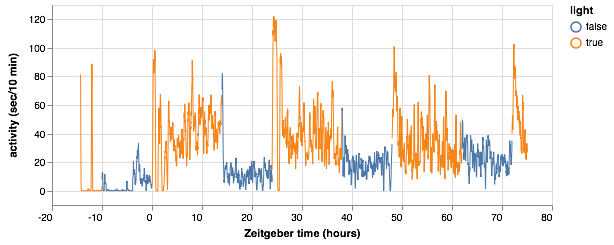

In [40]:
plot_trace(df, col='rolling activity', location=1, units='sec/10 min')

It is a bit less noise, but we still have an entry for every time point. This is because the `rolling()` object allows for overlapping rolling windows. We therefore only want every tenth entry in the `DataFrame`. More specifically, we only want every 10th entry for each fish in the `DataFrame`. We can build a new, resampled `DataFrame` by taking every tenth entry for each fish. Here is where the `zeit_ind` column becomes really useful. We will just take every tenth time point using `zeit_ind[9::10]`. We can check to see if a given `zeit_ind` is in the list of `zeit_ind`s we want to keep using the `isin()` method.

In [41]:
# Get all zeit_inds, sorted
zeit_inds = np.sort(df['zeit_ind'].unique())

# Select every tenth, starting at the tenth
zeit_inds = zeit_inds[9::10]

# Keep all entries matching the zeit_inds in the DataFrame
df_resampled = df.loc[df['zeit_ind'].isin(zeit_inds), :]

# Drop original activity column
del df_resampled['activity']

# Rename the rolling activity column to activity
df_resampled = df_resampled.rename(columns={'rolling activity': 'activity'})

# Take a look
df_resampled.head(n=10)

location                time       zeit  zeit_ind  day genotype  light  \
9          1 2013-03-15 18:40:09 -14.330833      -860    4      het   True   
19         1 2013-03-15 18:50:09 -14.164167      -850    4      het   True   
29         1 2013-03-15 19:00:09 -13.997500      -840    4      het   True   
39         1 2013-03-15 19:10:09 -13.830833      -830    4      het   True   
49         1 2013-03-15 19:20:09 -13.664167      -820    4      het   True   
59         1 2013-03-15 19:30:09 -13.497500      -810    4      het   True   
69         1 2013-03-15 19:40:09 -13.330833      -800    4      het   True   
79         1 2013-03-15 19:50:09 -13.164167      -790    4      het   True   
89         1 2013-03-15 20:00:09 -12.997500      -780    4      het   True   
99         1 2013-03-15 20:10:09 -12.830833      -770    4      het   True   

        activity  
9   8.050000e+01  
19  1.300000e+00  
29  6.883383e-15  
39  6.883383e-15  
49  6.883383e-15  
59  6.883383e-15  
69  6.883383e-15  
79  6.883383e-15  
89  6.883383e-15  
99  1.100000e+00

Looks good! Now let's make a plot of the trace for the fish in location 1.

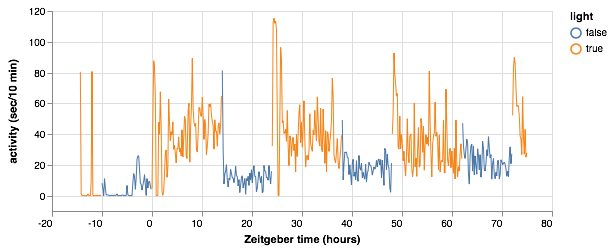

In [42]:
plot_trace(df_resampled, col='activity', location=1, units='sec/10 min')

#### Resampling using the resample method

There are a few small problems with this. First, we might not want to resample past boundaries between light and dark, because then we get time points that contain both light and dark moments. Secondly, what if the time points are not evenly sampled? If not, by using a fixed window of 10 time points, we may be sampling *time* windows of varying lengths.

For this second point, we can check the difference between respective time point to see if the data are evenly sampled.

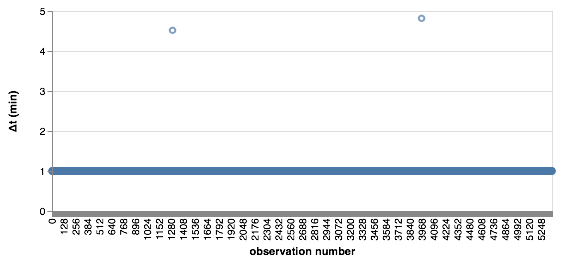

In [43]:
# Compute difference between time points in units of minutes
delta_t = np.diff(df.loc[df['location']==1, 'time']).astype(float) / 60 / 1e9

# Store in a data frame
df_delta_t = pd.DataFrame({'observation number': np.arange(len(delta_t)),
                           'Δt (min)': delta_t})

# Plot the differences
alt.Chart(df_delta_t,
        height=200,
        width=500
    ).mark_point(
    ).encode(
        x='observation number:O',
        y='Δt (min):Q'
    )

A ha! There are two measurements where there is almost five minutes between time points. This is because the experimenter, in this case, had to check the instrument and momentarily pause acquisition. Here is a big, bold statement:

> **It is imperative that you validate your data sets.**

You need to know about these possible discrepancies **before** performing data analysis. If you are assuming equal time steps, and they are not equal, you need to know that before doing your analysis. We will talk more about validation next week.

Now, we can alleviate these problems by using Pandas's built-in `resample()` method, which works on `DataFrameGroupBy` objects. It uses datetime columns to resample data to different time windows. Like we created a `RollingGroupby` object before, we can make an analogous resampling object.

In [44]:
grouped = df.groupby('location')
resampler = grouped.resample('10min', on='time')

# Take a look
resampler

DatetimeIndexResamplerGroupby [freq=<10 * Minutes>, axis=0, closed=left, label=left, convention=e, base=0]

Notice that we provided the `resample()` method with the argument `'10min'`, which tells it we want to resample to ten-minute intervals, and the `on='time'` kwarg says to use the `'time'` column for resampling. For instructions on the strings for specifying the resampling frequency (in this case `'10min'`), see [this](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases).

Now that we know we're resampling, we can compute sums. We will start by summing, which is out goal; we want to know how many seconds of activity the fish had in 10 minutes.

In [45]:
resampler.sum()['activity'].head()

location  time               
1         2013-03-15 18:30:00    77.3
          2013-03-15 18:40:00     4.5
          2013-03-15 18:50:00     0.0
          2013-03-15 19:00:00     0.0
          2013-03-15 19:10:00     0.0
Name: activity, dtype: float64

We see that the resampler uses exact 10-minute intervals; that is it gives you the result at 18:30, 18:40, etc. This alleviates the problem of uneven sampling, in that it only aggregates over real time. However, there are some possible problems with this.

1. Because it forces the time intervals to be on whole-ten-minute intervals, there is some clipping, since the minutes measured start and end on fractional minutes. It is important to understand how this rounding works, and what possible effects it might have on your subsequent analyses.
2. Some time intervals have fewer observations than others. If we looked at the mean activity per minute on those intervals, we're ok (though some are undersampled compared to others), but if we sum, some intervals will show lower activity when the fish are just as active. So, if we want seconds of activity per 10 minutes, we should adjust the sums to scale with the number of measurements contained in the interval.
3. Because the lights on and lights off times are at 9:00:00 and 23:00:00, we have dealt with the problem of resampling across lights on/off events. However, if this were not the case, this strategy would not deal with that.

Now, we will fix problem (2) above by taking the mean, and then scaling it according to how many observations there were using the `count()` method of the resampler.

In [46]:
# Resample with summing
activity_resampled = resampler.sum()['activity']

# Rescale sum with count
activity_resampled *= 10 / resampler.count()['activity']

# Reset the index
activity_resampled = activity_resampled.reset_index()

# Take a look
activity_resampled.head()

location                time   activity
0         1 2013-03-15 18:30:00  85.888889
1         1 2013-03-15 18:40:00   4.500000
2         1 2013-03-15 18:50:00   0.000000
3         1 2013-03-15 19:00:00   0.000000
4         1 2013-03-15 19:10:00   0.000000

Now we have activity, more or less properly resampled for ten minute intervals. I saw "more or less" because there is still issue (1) above, that we are forcing whole-minute time stamps, resulting in some error around when lights switch on and off. There is little we can do about this, though, since the experiment did not begin and end on whole-minute intervals, whereas lights on and off are exactly on a minute.

While we have the `'location'`, `'time'`, and `'activity'` times properly resampled, we need to get the other columns as well. We can use the `first()` method of the resampler to get those entries (since we do not want to sum over them). The `first()` method gives the first entry in the resampled interval.

In [47]:
# Get a new DataFrame, resampled without summing.
df_resampled = resampler.first()

# Resampling happened on activity and time columns; delete
del df_resampled['time']
del df_resampled['location']

# Reset index so resampled location and time indices become columns
df_resampled = df_resampled.reset_index()

# Add in the properly resampled activity
df_resampled['activity'] = activity_resampled['activity']

# Take a look
df_resampled.head()

location                time   activity       zeit  zeit_ind  day genotype  \
0         1 2013-03-15 18:30:00  85.888889 -14.480833      -869    4      het   
1         1 2013-03-15 18:40:00   4.500000 -14.330833      -860    4      het   
2         1 2013-03-15 18:50:00   0.000000 -14.164167      -850    4      het   
3         1 2013-03-15 19:00:00   0.000000 -13.997500      -840    4      het   
4         1 2013-03-15 19:10:00   0.000000 -13.830833      -830    4      het   

   light  rolling activity  
0   True               NaN  
1   True      8.050000e+01  
2   True      1.300000e+00  
3   True      6.883383e-15  
4   True      6.883383e-15

This is fine, except for the `'rolling activity'` column is a remnant from the earlier analysis we did, so we should delete it. Furthermore, the `'zeit'` column is no longer representing the `'time'` column, since that has been resampled. When we applied the `first()` method of the resampler, it did not know that `'zeit'` is connected to the time. So, we need to re-compute the `'zeit'` columns.

In [48]:
# Set the Zeitgeber time
zeitgeber_0 = pd.to_datetime('2013-03-16 9:00:00')
df_resampled['zeit'] = (df_resampled['time'] - zeitgeber_0).dt.total_seconds() / 3600

# Delete rolling activity
del df_resampled['rolling activity']

# Take a look
df_resampled.head()

location                time   activity       zeit  zeit_ind  day genotype  \
0         1 2013-03-15 18:30:00  85.888889 -14.500000      -869    4      het   
1         1 2013-03-15 18:40:00   4.500000 -14.333333      -860    4      het   
2         1 2013-03-15 18:50:00   0.000000 -14.166667      -850    4      het   
3         1 2013-03-15 19:00:00   0.000000 -14.000000      -840    4      het   
4         1 2013-03-15 19:10:00   0.000000 -13.833333      -830    4      het   

   light  
0   True  
1   True  
2   True  
3   True  
4   True

Great! Now we can make a plot of these resampled data.

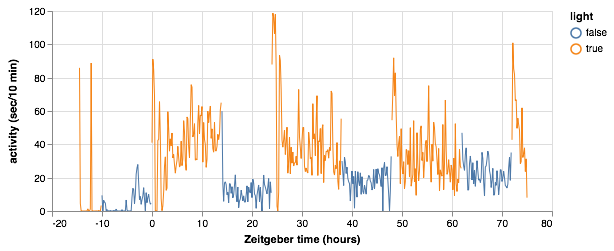

In [49]:
plot_trace(df_resampled, units='sec/10 min')

Nice! This does not look too dissimilar to what we did before, but we can rest assured that we took better care of missing time points.

## Saving your work, and your pipeline

When wrangling data as we have done, it is important to have code and documentation that will perform *exactly* the same steps as you did to organize your data. This is true of the entire data analysis process, from notes on acquisition to validation to wrangling to inference and reporting. Jupyter notebooks can help, but it is often useful to have functions to do the analysis pipeline you would typically do. For example, you could write a function to generate the resampled `DataFrame` we just generated from the original data.

In [50]:
def load_and_resample(activity_file, genotype_file, zeitgeber_0, resample_rule=None):
    """Load and resample activity data.
    Assumes genotype file has columns corresponding 
    to wild type, heterozygote, and mutant.
    """
    # Load in the genotype file, call it df_gt for genotype DataFrame
    df_gt = pd.read_csv(genotype_file,
                        delimiter='\t',
                        comment='#',
                        header=[0, 1])
    
    # Rename columns
    df_gt.columns = ['wt', 'het', 'mut']
    
    # Melt to tidy
    df_gt = pd.melt(df_gt, var_name='genotype', value_name='location').dropna()
    
    # Reset index
    df_gt = df_gt.reset_index(drop=True)
    
    # Integer location names
    df_gt.loc[:,'location'] = df_gt.loc[:, 'location'].astype(int)
    
    # Read in activity data
    df = pd.read_csv(activity_file, comment='#')
    
    # Merge with genotype data
    df = pd.merge(df, df_gt)
    
    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # Column for light or dark
    df['light'] = (  (df['time'].dt.time >= pd.to_datetime('9:00:00').time())
                   & (df['time'].dt.time < pd.to_datetime('23:00:00').time()))
    
    if resample_rule is None:
        df_resampled = df
    else:
        # Group by location
        gb = df.groupby('location')

        # Make resampler
        resampler = gb.resample(resample_rule, on='time')

        # Resample with summing
        activity_resampled = resampler.sum()['activity']

        # Rescale sum with count
        activity_resampled *= 10 / resampler.count()['activity']

        # Reset the index
        activity_resampled = activity_resampled.reset_index()

        # Get a new DataFrame, resampled without summing.
        df_resampled = resampler.first()

        # Resampling happened on activity and time columns; delete
        del df_resampled['time']
        del df_resampled['location']

        # Reset index so resampled location and time indices become columns
        df_resampled = df_resampled.reset_index()

        # Add in the properly resampled activity
        df_resampled['activity'] = activity_resampled['activity']

    # Set the Zeitgeber time
    zeitgeber_0 = pd.to_datetime(zeitgeber_0)
    df_resampled['zeit'] = (df_resampled['time'] - zeitgeber_0).dt.total_seconds() / 3600

    return df_resampled

Of course, this function makes strong assumptions about the structure of the data files, which needs to be verified in first in order to use the function. It should also have a much more descriptive doc string explaining these things.

Now that we have a function, we can use it to load in the original data sets and then generate the resampled tidy data frame.

In [51]:
df = load_and_resample('../data/130315_1A_aanat2.csv', 
                       '../data/130315_1A_genotypes.txt', 
                       '2013-03-16 9:00:00',
                       resample_rule='10min')

We may also want to save the processed `DataFrame` to a CSV file. This can be done using the `to_csv()` method of a `DataFrame`.

In [52]:
df.to_csv('../data/130315_1A_aanat2_resampled.csv', index=False)

## Conclusions (and a lesson about validation)

In this tutorial, you learned about the power of tidy data and split-apply-combine. The "apply" step can be an aggregation, such as computing a summary statistic like the mean or standard deviation, or an transformation, like a resampling or rolling mean. Pandas provided useful tools to enable this kind of calculation.

You also learned that knowing the structure of your data set is imperative. Even though the activity data set came in tidy, we still made key assumptions about it. Some of these assumptions are:

1. The time samples are evenly spaced.
2. There are no missing data points.
3. Each location has the same time points.

We relied on these assumptions as we did resampling and computed summary statistics about the data.

There are also many other hidden assumptions. For example, we assume that the values of the activity are all between zero and sixty. If there are not, something went wrong.

This underscores the importance of **data validation** *before* analysis. That is the topic of one of next week's tutorials.

## Computing environment

In [55]:
%load_ext watermark

In [56]:
%watermark -v -p numpy,pandas,altair,jupyterlab

CPython 3.7.0
IPython 6.5.0

numpy 1.15.1
pandas 0.23.4
altair 2.2.2
jupyterlab 0.34.9
